ValueError: Columns must be same length as key

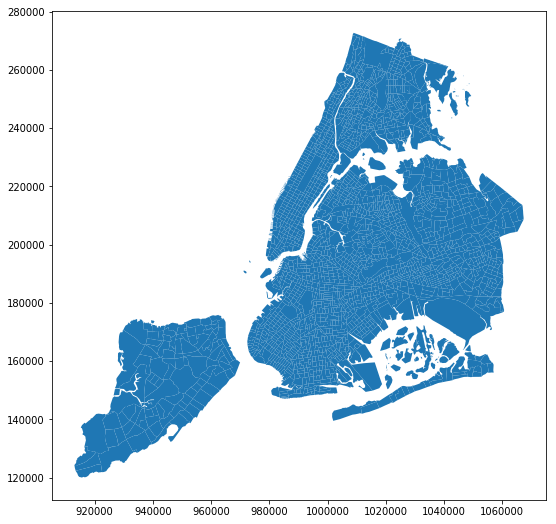

In [2]:
#%%     
# Plotting the census tracts for all reports that appeared in a specific month                    
# import contextily as ctx
# import matploylib.pyplot as plt
import geopandas as gp
import os
import platform
import pandas as pd
import numpy as np

# shapeFile = "NYU_NYC_ShapeFile/nyu_2451_34513.shp"
shapeFile = "NYU_NYC_34505_SP/nyu_2451_34505.shp"
csvFile = "GasHistory_2010_ReportFrequency_Monthly.csv"
monthlyDF = pd.read_csv(csvFile)                                                                            # Read the csv file and make a data frame
shapeGDF = gp.read_file(shapeFile)                                                                           # Read the shape file and make a data frame
shapeGDF.plot(figsize = (10,9))

GDF_TRACT_COL = "name"
DF_TRACT_COL  = "CensusTract_2010"

# ADDING AND CHANGING DATATYPE OF COLS SO WE CAN COMPARE THEM:
shapeGDF["TotalMonthlyReport" ] = int
shapeGDF["MonthYear"] = str                                                                               # adding two new cols to shapeGDF
shapeGDF[[GDF_TRACT_COL]] = shapeGDF[[GDF_TRACT_COL]].apply(pd.to_numeric).astype(float)                                      # Turning GDF_TRACT_COL - the CensusTract number to numpy.int64 values so can query them
shapeGDF[['tractid']] = shapeGDF[['tractid']].apply(pd.to_numeric).astype(int)  
shapeGDF[['tractnum']] = shapeGDF[['tractnum']].apply(pd.to_numeric).astype(int)  
shapeGDF[['bcode']] = shapeGDF[['bcode']].apply(pd.to_numeric).astype(int) 

monthlyDF[[DF_TRACT_COL]] = monthlyDF[[DF_TRACT_COL]].apply(pd.to_numeric).astype(float)    # Turning "Year" and "CensusTract" to numpy.int64 values so can query them (name col is in int while CensusTract is in float)
monthlyDF[['CensusTract_2010_ID']] = monthlyDF[['CensusTract_2010_ID']].apply(pd.to_numeric).astype(int)
monthlyDF[['Month', 'Year']] = monthlyDF.MonthYear.str.split("-",expand=True)                               # Splitng the "MonthYear" column into "Month", "Year" for easier querying
monthlyDF[['Year']]        = monthlyDF[['Year']].apply(pd.to_numeric).astype(int)    # Turning "Year" and "CensusTract" to numpy.int64 values so can query them (name col is in int while CensusTract is in float)

monthlyDF = monthlyDF.sort_values(by=["Year", "Month", DF_TRACT_COL], ascending=[False, False, True])
monthlyDF = monthlyDF.reset_index(drop=True)

## SEE WHAT TRACTS ARE IN CONED SITE BUT NOT IN THE SHAPE FILE:
conSet = set()
shpSet = set()
for i in range(0, len(monthlyDF)):
    conSet.add(monthlyDF.iloc[i][DF_TRACT_COL])
for i in range(0, len(shapeGDF)):
    shpSet.add(shapeGDF.iloc[i][GDF_TRACT_COL])
conSet = list(conSet)
shpSet = list(shpSet)
conSet.sort()
noneCount = 0
s=""
noneTracts = []
for i in range(0, len(conSet)):
    if conSet[i] not in shpSet:
        s=s+str(conSet[i])+", "
        noneTracts.append(float(conSet[i]))
        noneCount = noneCount +1
# print("Census Tracts not in GDF:\n"+s+"\n")
print("Number of Census Tracts in ConEdison data: "+str(len(conSet)))
print("Number of Census Tracts in Shapefile:      "+str(len(shpSet)))
print("Number of Census Tracts missing from Shapefile: "+str(noneCount))
print("----------------------------------")

# Making a new empty gdf for each month
thisMonthPlotGDF = shapeGDF.copy()
print("Creating GDF for particular months in monthly report freq data...")
skipIndex = []
count = 0
for row in range(0,len(monthlyDF)):
    thisMonthPlotGDF.drop(thisMonthPlotGDF.index, inplace=True)                           # resetting the month df for this new month
    if row in skipIndex:
        continue

    # 1) Getting all the census tracts of this month
    thisMonthsDF = monthlyDF.loc[                                                                           # thisMonthsDF = df that contains all rows for that month-year
        (monthlyDF['MonthYear']  == monthlyDF['MonthYear'][row]) 
    ]      
    if len(thisMonthsDF) == 0:                                                                              # If these r no reports for this month-year so skip
        continue
    skipIndex.extend(thisMonthsDF.index.tolist()) 
    thisMonthsDF = thisMonthsDF.reset_index(drop=True)
    censusForThisMonth = thisMonthsDF.CensusTract_2010.tolist()                                                  # need to put census tracts into an array, if i use directly from thisMonthsDF i get errors when there is no 
    thisMonth = monthlyDF['MonthYear'][row]

    # 2) FIND BLOCKS FOR EACH TRACT: We have the list of census tracts for this month. Will find all census block geometries for each tract in array. Will put all block geometries that make up the particular tract in tractShapesGDF and append it to thisMonthPlotGDF to have geometries for all tracts of the month
    for tractRow in range(0, len(censusForThisMonth)):
        tractShapesGDF = shapeGDF.loc[                                                                         # this df that contains all census block geometries to make each tract
            np.equal(shapeGDF[GDF_TRACT_COL], censusForThisMonth[tractRow])
        ]  
        if len(tractShapesGDF) == 0:
            if censusForThisMonth[tractRow] not in noneTracts:
                print("*** No geoid/census block for this CensusTract: " + str(censusForThisMonth[tractRow]) + " *********************** NOT EXPECTED!")
            continue
        thisMonthPlotGDF = thisMonthPlotGDF.append(tractShapesGDF)                                          # append the block geometries gdf to this months gdf so we can plot this tract
    thisMonthPlotGDF = thisMonthPlotGDF.reset_index(drop=True)  
    
    # 3) Now that i have the census Tract geometires for this month, Go through the the GDF and edit the "MonthYear" and "TotalMonthlyReport" 
    for gdfRow in range(0, len(thisMonthPlotGDF)):
        # if thisMonth == "January-2019":
        gdfRow_tract = thisMonthPlotGDF.iloc[gdfRow][GDF_TRACT_COL]
        rowN = np.where(thisMonthsDF[DF_TRACT_COL] == gdfRow_tract)[0]
        gotRepNum = int(str(list(thisMonthsDF.iloc[rowN]['TotalReports'])).strip('[').strip(']'))#.strip("""'""").strip(' ') #got report number from the thisMonthsDF by getting the row were the Census Tract is from the PlotGDF and using the row# and TotalReports col name to get the report number
        thisMonthPlotGDF.at[gdfRow, "TotalMonthlyReport"] = gotRepNum
        thisMonthPlotGDF.at[gdfRow, "MonthYear"] = thisMonth
    
    # 4) Now that i have the geo dataframe to plot all the census tracts of the month, can now plot them:

    # df = gp.read_file(gp.datasets.get_path('nybb'))
    # ax = df.plot(figsize=(10, 10), alpha=0.5, edgecolor='k')
    # df = df.to_crs(epsg=3857)
    # fig, ax = plt.subplots(1,1
    # df1.plot.(ax=ax))
    ax = shapeGDF.plot(alpha=0.08, figsize = (14,13))
    map = thisMonthPlotGDF.plot(column='TotalMonthlyReport',cmap = 'Reds', edgecolor='black', linewidth = 0.3, figsize = (14,11),legend = True, ax=ax)#, ax=ax, alpha=1) #10,8
    map.set_title(label = 'Number of Gas Leak Reports per Census Tract for\n{0}\n(Showing {1} Tracts, {2} GeoIDs)'.format(thisMonth, len(censusForThisMonth), len(thisMonthPlotGDF)), fontdict={'fontsize': 20}, loc='center')
    if len(censusForThisMonth) != 0 and len(thisMonthPlotGDF) != 0: #there is a month that has one tract but no geoid! so cant get the legend
        leg = map.get_legend()
        leg.set_title('Number Of Reports')
        leg.set_bbox_to_anchor((1.1,0.5,0.1,0.5))                          # Adjusted numbers to find the best location and size of the legend

# %%